In [1]:
from pgn2gif import chess
import numpy as np
from openTSNE import TSNE
from openTSNE.callbacks import ErrorApproximations
from matplotlib import pyplot as plt
from scipy import interpolate
import re
import pandas as pd
from custom_chess_utils.utils import *
from umap.parametric_umap import ParametricUMAP
from matplotlib import pyplot as plt
import tensorflow as tf
seed = 2
np.random.seed(seed)
tf.random.set_seed(seed)

chess_games_path = '/mnt/d/Work/CG Institute/chess/lichess data/lichess_db_standard_rated_2021-08.pgn'
pgn_folder = 'games'
umap_path = 'lichess_param_umap_custom_seed'+str(seed)+'.csv'

2022-01-13 11:57:16.685448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 11:57:16.685508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data loading and preprocessing

#### Extract individual games from PGN file

In [2]:
split_games = extract_individual_games_from_pgn(chess_games_path, pgn_folder, lines_to_read=800000)

#### Filter out games without eval score or without clk

In [3]:
split_games = get_games_with_eval_and_clk(split_games)
print(len(split_games))

2228


#### keep n games

In [4]:
n_games = 250
split_games = split_games[:n_games]
print(len(split_games))

250


#### store individual games as PGN files

In [5]:
store_games_as_pgn(split_games, pgn_folder)
game_paths = [pgn_folder+'/game-{:05d}.pgn'.format(n+1) for n in range(n_games)]

#### Loading games from individual PGN files

In [6]:
game_paths_checked, metadata, metadata_evals, metadata_clks, md_keys = get_metadata_from_pgns(game_paths)
print(md_keys)

['WhiteElo', 'Site', 'White', 'ECO', 'UTCDate', 'Date', 'Termination', 'TimeControl', 'Result', 'Opening', 'Round', 'Event', 'BlackElo', 'Black', 'UTCTime']


In [7]:
game_matrices, games_pgn = game_matrices_from_pgn(pgn_folder, game_paths_checked, first_moves_filter=None)
print(len(game_matrices))

250


#### keep opening moves only
using the list of openings that corresponds to the lichess dataset https://github.com/niklasf/chess-openings

In [8]:
eco_df = get_eco_df('ECOs')

#### add ECO category (A,B,C,D,E,F) to metadata

In [9]:
metadata = create_opening_categories_feature(metadata)

#### filter games with Openings that don't exist in our ECO dataset

In [10]:
game_matrices, metadata, metadata_evals, metadata_clks, games_pgn = filter_unknown_ecos(eco_df, game_matrices, metadata, metadata_evals, metadata_clks, games_pgn)

#### using eco dataframe to determine amount n of moves in the corresponding opening, cutting off each game after n

In [11]:
game_matrices = cut_off_games_after_opening(game_matrices, eco_df, metadata)

#### get captured pieces throughout games and turns

In [12]:
captures, _ = get_captures(game_matrices, games_pgn)

#### concatenate games into final data that will be projected

In [13]:
final_data = np.concatenate(game_matrices)

### Calculating Embeddings / Projections and Writing to Files

#### define the network, create UMAP object

In [14]:
dims = (8, 8, 13)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=16, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation="relu", padding="same"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 16)          1888      
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               2

2022-01-13 11:57:31.103048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-13 11:57:31.103102: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-13 11:57:31.103123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-857SMRC): /proc/driver/nvidia/version does not exist


In [15]:
keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    )
]}

In [16]:
# pass encoder network to ParametricUMAP
reducer = ParametricUMAP(
    verbose=True,
    keras_fit_kwargs = keras_fit_kwargs,
    encoder=encoder,
    dims=dims,
    random_state=seed,
    n_training_epochs=20)

#### project using parametric UMAP

In [17]:
umap_embedding = reducer.fit_transform(final_data)

ParametricUMAP(dims=(8, 8, 13),
               encoder=<keras.engine.sequential.Sequential object at 0x7f108fec0580>,
               keras_fit_kwargs={'callbacks': [<keras.callbacks.EarlyStopping object at 0x7f1090769c70>]},
               n_training_epochs=20,
               optimizer=<keras.optimizer_v2.adam.Adam object at 0x7f1090769e80>)
Construct fuzzy simplicial set
Thu Jan 13 11:57:34 2022 Finding Nearest Neighbors
Thu Jan 13 11:57:37 2022 Finished Nearest Neighbor Search
Thu Jan 13 11:57:39 2022 Construct embedding
Epoch 1/200
6/6 [==============================] - 2s 114ms/step - loss: 6.3410
Epoch 2/200
6/6 [==============================] - 1s 113ms/step - loss: 2.1273
Epoch 3/200
6/6 [==============================] - 1s 98ms/step - loss: 0.6989
Epoch 4/200
6/6 [==============================] - 1s 98ms/step - loss: 0.5924
Epoch 5/200
6/6 [==============================] - 1s 98ms/step - loss: 0.5790
Epoch 6/200
6/6 [==============================] - 1s 104ms/step - loss: 0

Text(0.5, 0, 'Epoch')

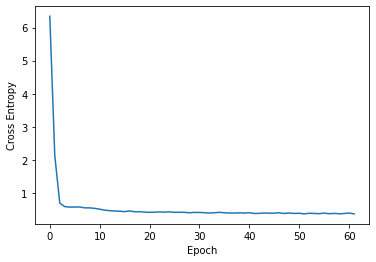

In [18]:
fig, ax = plt.subplots()
ax.plot(reducer._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

#### reshape resulting embedding into games, states, 2

In [19]:
umap_embedding_split = reshape_embedding(umap_embedding, game_matrices)

#### create resulting csv file using all metadata and embedding

In [20]:
write_csv(umap_path, md_keys, umap_embedding_split, game_matrices, metadata, captures, metadata_evals, metadata_clks)